Match predicter for national football

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

#import
df = pd.read_csv('results.csv')

In [62]:
#filtering
rel_tournaments = [
    'FIFA World Cup',
    'UEFA Nations League',
    'UEFA Euro',
    'AFC Asian Cup',
    'African Cup of Nations',
    'Gold Cup',
    'Copa América',
    'Oceania Nations Cup'
]

df_filtered = df[df['tournament'].isin(rel_tournaments)].copy() #why copy?

df_filtered = df_filtered[['date','home_team','away_team','home_score','away_score','tournament']]

In [55]:
#print first lines
print(df_filtered.head())

           date  home_team away_team  home_score  away_score    tournament
478  1916-07-02      Chile   Uruguay           0           4  Copa América
480  1916-07-06  Argentina     Chile           6           1  Copa América
481  1916-07-08     Brazil     Chile           1           1  Copa América
482  1916-07-10  Argentina    Brazil           1           1  Copa América
484  1916-07-12     Brazil   Uruguay           1           2  Copa América


create pred. var


In [63]:
def determineResult(row):
    if row['home_score'] > row['away_score']:
        return 'H'  # Home won
    elif row['home_score'] < row['away_score']:
        return 'A'  # Away won
    else:
        return 'D'  # tie

df_filtered['result'] = df_filtered.apply(determineResult, axis=1)

*Prepare train test data

In [78]:
#simple feature engineering
le = LabelEncoder()
all_teams = pd.concat([df_filtered['home_team'], df_filtered['away_team']]).unique()
le.fit(all_teams)

df_filtered['home_id'] = le.transform(df_filtered['home_team'])
df_filtered['away_id'] = le.transform(df_filtered['away_team'])

#create ids
tournament_encoder = LabelEncoder()
df_filtered['tournament_id'] = tournament_encoder.fit_transform(df_filtered['tournament'])

features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

df_filtered

,date,home_team,away_team,home_score,away_score,tournament,result,home_id,away_id,tournament_id
478,1916-07-02,Chile,Uruguay,0,4,Copa América,A,27,170,2
480,1916-07-06,Argentina,Chile,6,1,Copa América,H,4,27,2
481,1916-07-08,Brazil,Chile,1,1,Copa América,D,19,27,2
482,1916-07-10,Argentina,Brazil,1,1,Copa América,D,4,19,2
484,1916-07-12,Brazil,Uruguay,1,2,Copa América,A,19,170,2
...,...,...,...,...,...,...,...,...,...,...
48361,2025-06-29,Canada,Guatemala,1,1,Gold Cup,D,25,65,4
48362,2025-06-29,United States,Costa Rica,2,2,Gold Cup,D,169,33,4
48363,2025-07-02,United States,Guatemala,2,1,Gold Cup,H,169,65,4
48364,2025-07-02,Mexico,Honduras,1,0,Gold Cup,H,104,70,4


*train model:

In [65]:
#split data
X = df_filtered[features]
y = df_filtered[target]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
#actual model training
model_RF = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_split=2)

model_RF.fit(X_train, y_train)

y_pred = model_RF.predict(X_test)

In [67]:
#evaluate model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.44
              precision    recall  f1-score   support

           A       0.44      0.40      0.42       295
           D       0.25      0.19      0.22       221
           H       0.50      0.59      0.54       415

    accuracy                           0.44       931
   macro avg       0.40      0.40      0.39       931
weighted avg       0.42      0.44      0.43       931



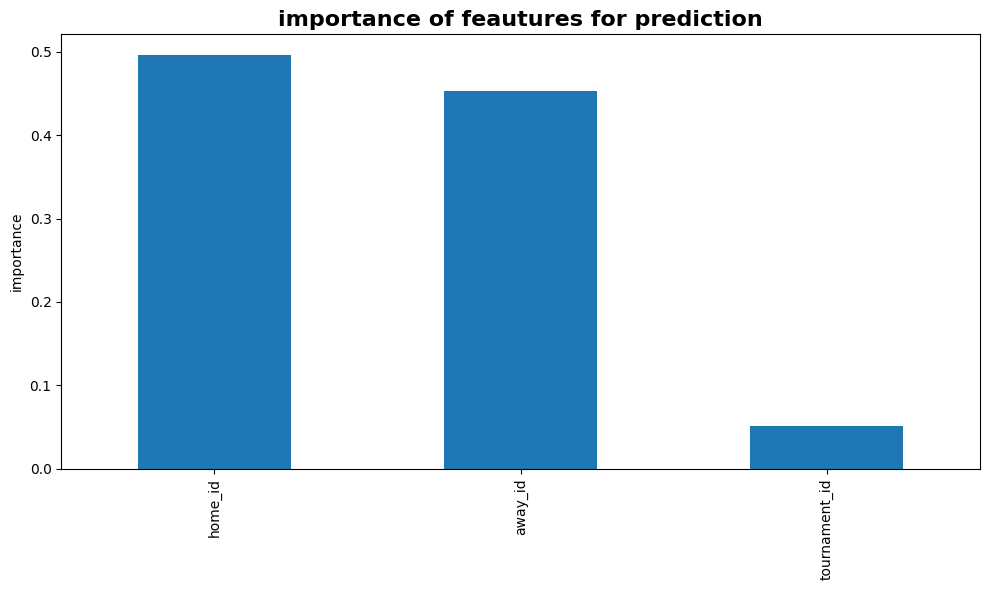

In [72]:
# Feature Importance des Modells
feature_importance = pd.Series(model_RF.feature_importances_, index=features)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('importance of feautures for prediction', fontsize=16, fontweight='bold')
plt.ylabel('importance')
plt.tight_layout()
plt.show()

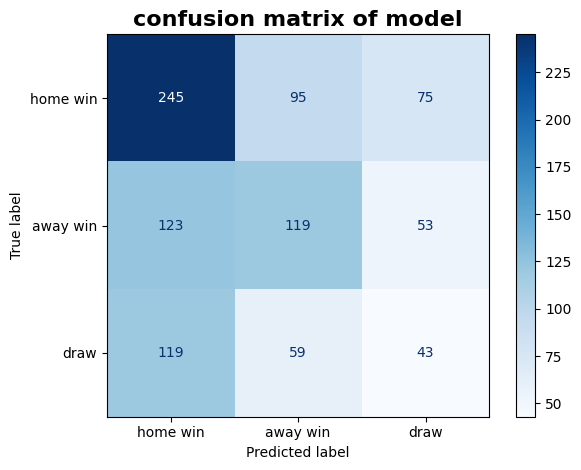

In [76]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['H', 'A', 'D'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['home win', 'away win', 'draw'])
disp.plot(cmap='Blues')
plt.title('confusion matrix of model', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()